<a href="https://colab.research.google.com/github/kauah23/D._Reconhecimento_Facial/blob/main/Reconhecimento_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from google.colab.patches import cv2_imshow

In [94]:
# 🔹 Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 🔹 Diretório do dataset de faces
train_dir = "/content/drive/MyDrive/face_dataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# 🔹 Carregar modelo pré-treinado ResNet50 sem a camada final
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# 🔹 Congelar camadas base
for layer in base_model.layers:
    layer.trainable = False

In [96]:
# 🔹 Adicionar novas camadas para classificação personalizada
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dense(2, activation="softmax")(x)  # 2 classes: "eu" e "irmão"

In [97]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=x)

In [98]:
# 🔹 Compilar o modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [99]:
# 🔹 Gerador de imagens para treino e validação
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode="categorical",  # Alterado para categorical (one-hot encoding)
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode="categorical",
    subset="validation"
)

Found 64 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [100]:
# 🔹 Treinamento do modelo
model.fit(train_generator, validation_data=val_generator, epochs=20)

# 🔹 Salvar o modelo treinado
model.save("/content/drive/MyDrive/modelo_resnet50_facial.h5")


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4615 - loss: 1.1218 - val_accuracy: 0.5000 - val_loss: 0.8495
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5601 - loss: 0.7832 - val_accuracy: 0.5625 - val_loss: 0.6434
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4120 - loss: 0.8406 - val_accuracy: 0.5625 - val_loss: 0.7402
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.6148 - loss: 0.6793 - val_accuracy: 0.5000 - val_loss: 0.9502
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5801 - loss: 0.7676 - val_accuracy: 0.5625 - val_loss: 0.8517
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5041 - loss: 0.7971 - val_accuracy: 0.5000 - val_loss: 0.5885
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7449 - loss: 0.5217 - val_accuracy: 1.0000 - val_loss: 0.5225
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9022 - loss: 0.4913 - val_accuracy: 1.0000 - val_loss: 0.5048
Epoch 9/

In [101]:
# 🔹 Caminho da imagem de teste
img_path = "/content/drive/MyDrive/face_dataset/usuario /IMG_20241230_153053.jpg"

# 🔹 Carregar e pré-processar a imagem de teste
img_cv2 = cv2.imread(img_path)
img_resized = cv2.resize(img_cv2, (224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img_resized) / 255.0
img_array = tf.expand_dims(img_array, axis=0)  # Adicionar dimensão do batch

# 🔹 Fazer previsão
predictions = model.predict(img_array)
predicted_class = "usuario" if predictions[0][0] > predictions[0][1] else "irmao"

# 🔹 Exibir resultado na imagem
cv2.putText(img_cv2, predicted_class, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2_imshow(img_cv2)  # Exibir corretamente no Google Colab

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [102]:
!pip install opencv-python tensorflow numpy

In [103]:
import cv2
import numpy as np
import tensorflow as tf

# Carregar o modelo treinado
model = tf.keras.models.load_model("/content/drive/MyDrive/modelo_resnet50_facial.h5")

# Carregar um detector de face do OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [104]:
# Iniciar captura de vídeo
cap = cv2.VideoCapture(0)  # Usa a webcam padrão

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Converter para tons de cinza (melhora a detecção)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detectar faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224))  # Redimensiona para entrada da ResNet
        face = np.expand_dims(face, axis=0) / 255.0  # Normaliza os valores

        # Fazer a previsão
        predictions = model.predict(face)
        label = "usuario" if np.argmax(predictions) == 0 else "irmao"

        # Desenhar caixa e nome
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Exibir imagem com as detecções
    cv2.imshow("Reconhecimento Facial", frame)

    # Pressionar 'q' para sair
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar recursos
cap.release()
cv2.destroyAllWindows()


A câmera será capturada em 5 segundos. Posicione-se...


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


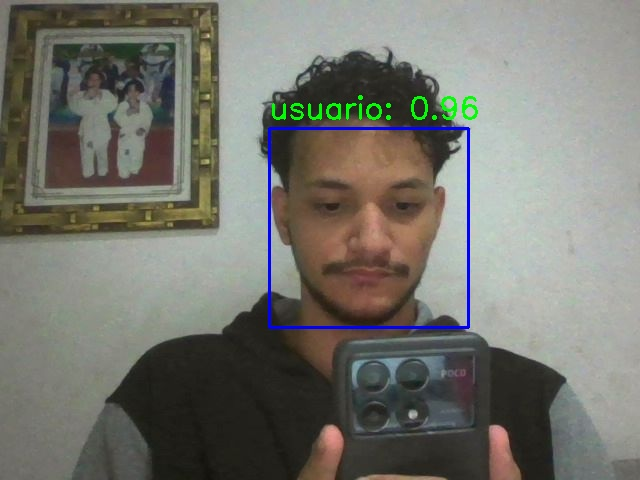

Imagem capturada após 5 segundos e salva como /content/captured_photo_after_delay.jpg.


In [111]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
import cv2
import numpy as np
import base64
from PIL import Image as PILImage
from io import BytesIO
import tensorflow as tf

# Carregar o modelo treinado ResNet50
model = tf.keras.models.load_model("/content/drive/MyDrive/modelo_resnet50_facial.h5")

# Função para capturar foto usando JavaScript
def take_photo_after_delay():
    js = Javascript('''
        async function takePhotoAfterDelay() {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();
            document.body.appendChild(video);
            await new Promise(resolve => setTimeout(resolve, 5000));
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            return canvas.toDataURL('image/jpeg', 0.8);
        }
    ''')
    display(js)
    return eval_js('takePhotoAfterDelay()')

# Função para converter a imagem em base64 para uma matriz do OpenCV
def js_to_image(js_reply):
    img_data = base64.b64decode(js_reply.split(',')[1])
    img = PILImage.open(BytesIO(img_data))
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

# Inicializa o modelo Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Função para preprocessar a imagem antes de passar para o modelo
def preprocess_face(img, target_size=(224, 224)):
    img_resized = cv2.resize(img, target_size)
    img_array = np.array(img_resized)
    img_array = img_array / 255.0  # Normalizar a imagem
    return np.expand_dims(img_array, axis=0)  # Adicionar dimensão extra para batch

# Função para classificar a pessoa detectada
def classify_face(model, img):
    img_preprocessed = preprocess_face(img)
    predictions = model.predict(img_preprocessed)
    class_idx = np.argmax(predictions, axis=1)[0]
    class_labels = ["usuario", "irmao"]  # Defina os rótulos que você usou para treinar o modelo
    return class_labels[class_idx], predictions[0][class_idx]

# Captura a imagem após 5 segundos
try:
    print("A câmera será capturada em 5 segundos. Posicione-se...")
    js_reply = take_photo_after_delay()
    img = js_to_image(js_reply)

    # Converte para escala de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detecta rostos
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # Se rostos forem detectados
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # Desenha caixa delimitadora
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Recorta a face
            face = img[y:y+h, x:x+w]

            # Classificar a face
            label, confidence = classify_face(model, face)

            # Adiciona o rótulo à imagem
            cv2.putText(img, f"{label}: {confidence:.2f}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Salva e exibe a imagem
        filename = '/content/captured_photo_after_delay.jpg'
        cv2.imwrite(filename, img)
        display(Image(filename))
        print(f"Imagem capturada após 5 segundos e salva como {filename}.")
    else:
        print("Nenhum rosto detectado.")

except Exception as e:
    print(f"Erro: {e}")